In [31]:
import bisect
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import seaborn as sns
from networkx.drawing.nx_pydot import graphviz_layout
import pydot

import dalmatian 
from fludarabine.helper import *
from scipy.stats import iqr

In [32]:
# Load wbc and treatment file 
wbc_file = '../../data/crc/inputs/CRC-0045_wbc.txt'
treatment = pd.read_csv("../../data/crc/inputs/CRC_0045.txt", sep = '\t')


# Get input files from Terra through dalmatian
patient = 'CLL-CRC-0045'
workspace ='broad-firecloud-ibmwatson/Getz-IBM-Wu_Fludarabine_Resistance-Analysis'
wm = dalmatian.WorkspaceManager(workspace)

participants = wm.get_participants()


cluster_CCF_df = pd.read_csv(participants.loc[patient]['cluster_ccfs_Aug2'], sep='\t')

abundance_df = pd.read_csv(participants.loc[patient]['abundances_tsv_Aug2'], sep='\t')
mcmc_df = pd.read_csv(participants.loc[patient]['cell_population_mcmc_trace_Aug2'], sep='\t')
tree_df = pd.read_csv(participants.loc[patient]['tree_tsv_Aug2'], sep='\t')

In [27]:
def load_wbc_file(file):
    """
    Parse wbc file

    Args:
        wbc file

    Returns:
        variables as a list

    """

    df = pd.read_csv(file, sep='\t')

    # Get all time points
    times = df.dfd.tolist()

    # Get times that are in the interpolation range
    t = pd.notna(df['sample_id'])
    sample_time_index = [i for i, x in enumerate(t) if x]
    first_sample_index = sample_time_index[0]
    last_sample_index = sample_time_index[-1]
    df_interpolate = df.iloc[first_sample_index:last_sample_index + 1, :]
    times_interpolate = df_interpolate.dfd.tolist()
    wbc_interpolate = df_interpolate.wbc.tolist()

    # Get all wbc points
    wbc = df.wbc.tolist()

    # Get the sample list
    sample_list = df.sample_id[pd.notna(df.sample_id)].tolist()

    # Get the times at sample points
    times_sample = df.dfd[pd.notna(df.sample_id)].tolist()

    # Get the wbc at sample points
    wbc_sample = df.wbc[pd.notna(df.sample_id)].tolist()

    # Get the times that are not at sample points
    times_others = sorted(list(set(times) - set(times_sample)))

    return times_sample, times, times_interpolate, wbc, wbc_interpolate, sample_list, wbc_sample, times_others

In [33]:
times_sample, times, times_interpolate, wbc, wbc_interpolate, sample_list, wbc_sample, times_others = load_wbc_file(wbc_file)

In [34]:
def select_wbc(dfd, times, wbc, times_sample):
    '''
    select wbc until the first treatment after last sequencing sample

    Args:
        dfd: first treatment dfd after last sequencing sample
    
    '''
    last_sample_time = times_sample[-1]

    times_selected = [time_ for time_ in times if time_ <= dfd]

    smallest_times_selected = max(times_selected)

    smallest_index = times.index(smallest_times_selected)

    wbc_selected = wbc[0: smallest_index+ 1]

    return times_selected, wbc_selected

In [35]:
times_selected, wbc_selected = select_wbc(4357, times, wbc, times_sample)

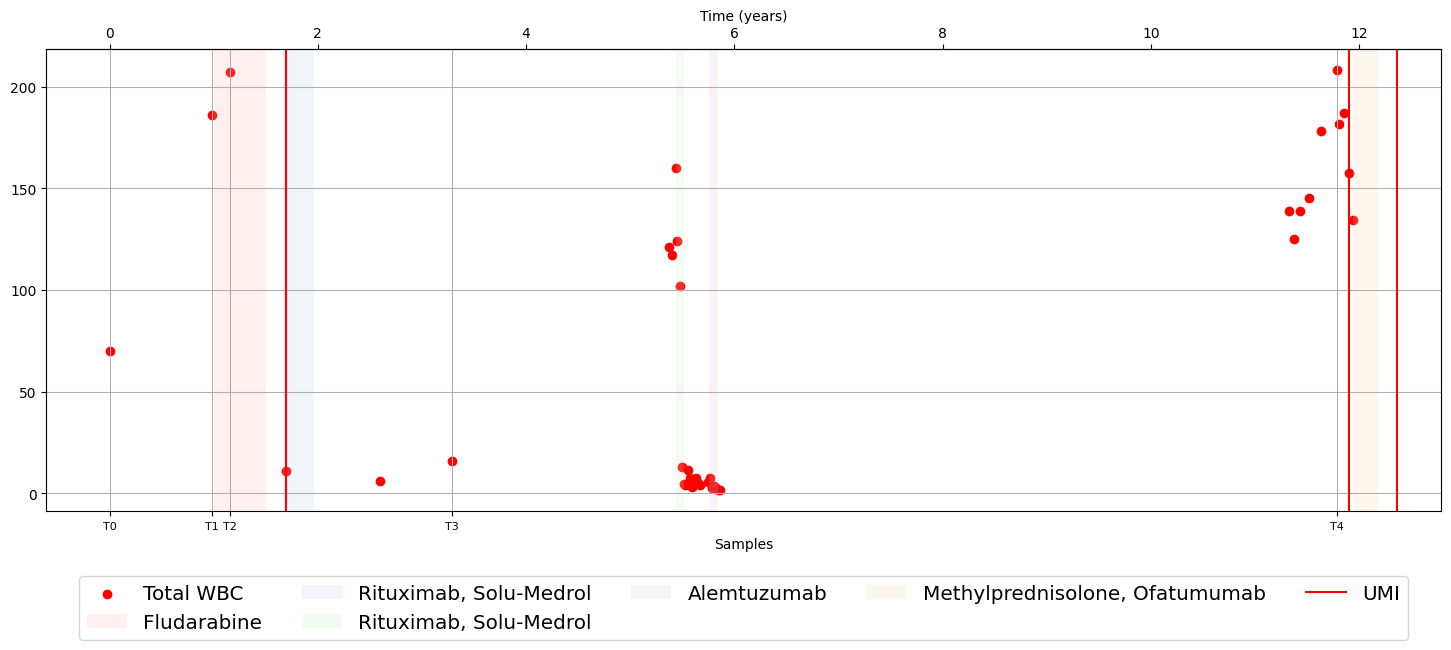

In [36]:
fig,ax = plt.subplots(1,1, figsize=(18,6))

number_samples = len(sample_list)
tick_list = ['T'+ str(i) for i in range(number_samples)]

x_year = [ i/365 for i in np.array(times_selected)]
ax.scatter(x_year,wbc_selected, label = 'Total WBC', c = 'red')

x_axis = [i/365 for i in times_sample]
ax.set_xticks(x_axis)

ax.set_xticklabels(tick_list, fontsize =8)
secax = ax.secondary_xaxis('top')
secax.set_xlabel("Time (years)")
ax.grid(True)


cmap = plt.get_cmap("Pastel1")
xlim = ax.get_xlim()[1]

for i, row in treatment.iterrows():
    treatment_name = row.tx
    start = row.tx_start/365
    end = row.tx_end/365
    if np.isnan(end):
        end = xlim
    length = end - start 
    center = (start + end)/2
#         color = color_dict[treatment_name]
    ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
    ax.set_xlabel('Samples')

# add potential UMI samples
ax.axvline(x=619/365, label ='UMI', color = 'red')
ax.axvline(x=4342/365,  color = 'red')
ax.axvline(x=4511/365,  color = 'red')
ax.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.3),fontsize = 'x-large')


Subclonal modeling

In [39]:
def plot_ccf(df, ax, times_sample):
    # Keep the necessary columns 
    cols = ['Sample_ID','Cluster_ID','postDP_ccf_mean','postDP_ccf_CI_low','postDP_ccf_CI_high' ]
    df = df[cols]
    cluster_list = df.Cluster_ID.unique().tolist()
    number_samples = len(df.Sample_ID.unique())
    
    tick_list = ['T'+ str(i) for i in range(number_samples)] 
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    

    for i in cluster_list:
        x = df[df.Cluster_ID == i].Sample_ID
        y = df[df.Cluster_ID == i].postDP_ccf_mean

        ci_low = df[df.Cluster_ID == i].postDP_ccf_CI_low
        ci_high = df[df.Cluster_ID == i].postDP_ccf_CI_high
        
#         if x_scale == 'sample':
#             x_axis = np.arange(0,number_samples) 
        
#         else:
#             x_axis = times_sample
        ax.plot(x_axis, y,c= ClusterColors.get_hex_string(i), marker ='o', label = i)
    
#         ax.plot(x_axis, y,c= ClusterColors.get_hex_string(i), marker ='o')
        ax.fill_between(x_axis, ci_low, ci_high, color= ClusterColors.get_hex_string(i), alpha = 0.1)
        
        
        
        ax.set_xlabel('Samples')
        ax.set_xticks(x_axis)

        ax.set_xticklabels(tick_list, fontsize =8)

        ax.set_ylabel('CCF')
        ax.legend()
        
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2

#         ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
        ax.axvspan(xmin = start, xmax= end,  facecolor= cmap(i), alpha = 0.2)

#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')

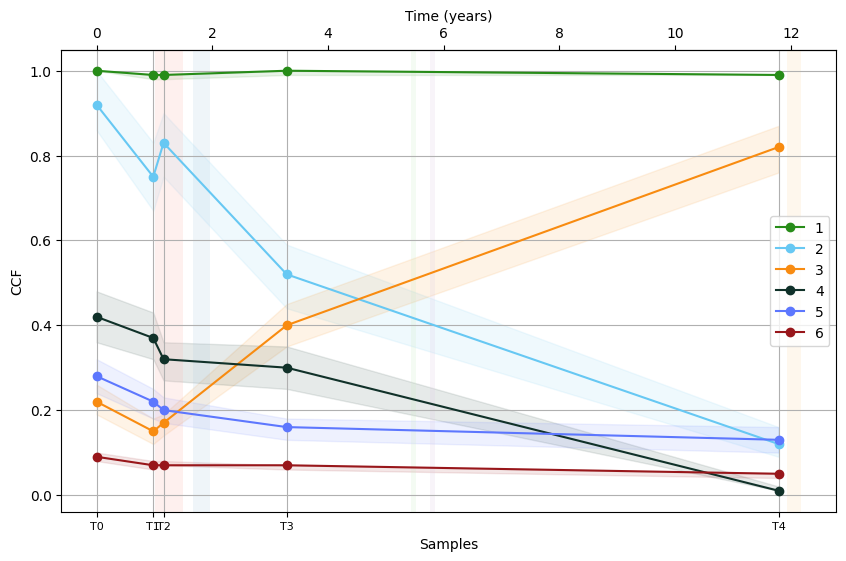

In [40]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_ccf(cluster_CCF_df,ax, times_sample )

In [41]:
def interpolate_abundance(abundance, mcmc, mode="interpolate_only"):
    """
    Parse abundance file and get abundance information and calculate interpolated abundance

    Args:
        cell_population_abundance file and mcmc_trace file
        mode: "interpolate_only" or "extrapolate"

    Returns:
        lists

    """

    cluster_map = {}

    # Get the cluster list from the mcmc file
    cluster_list = mcmc.Cluster_ID.unique().tolist()

    # Map the abundacne to each cluster in a dictionary
    for cluster_id in cluster_list:
        abundance['cluster'] = abundance['Cell_population'].str.split('_').str[-1].str[2:].astype(int)

        cluster_map[cluster_id] = abundance[abundance.cluster == cluster_id]

    ## To get abundance information from the cell_population_abundances.tsv
    cluster_abundance = {}
    for cluster_id, abundances in cluster_map.items():
        cluster_abundances = []
        ## iterate through the samples in the wbc file to make sure the order is correct
        for sample_name in sample_list:
            sample_abundances = float(abundances[abundances.Sample_ID == sample_name].Cell_abundance)
            cluster_abundances.append(sample_abundances / 100)
        cluster_abundance[cluster_id] = cluster_abundances

    ## To calculate interpolated abundance
    inter_abundance = {}
    for cluster_id, abundance in cluster_abundance.items():
        abundance_first = abundance[0]
        abundance_last = abundance[-1]
        if mode == "extrapolate":
            interpolate_func = interpolate.interp1d(times_sample, abundance, bounds_error=False,
                                                    fill_value=(abundance_first, abundance_last))
            abundance_interpolate = interpolate_func(times)

        if mode == "interpolate_only":
            interpolate_func = interpolate.interp1d(times_sample, abundance)

            abundance_interpolate = interpolate_func(times_interpolate)

        inter_abundance[cluster_id] = list(abundance_interpolate)

    return cluster_list, cluster_abundance, inter_abundance

In [42]:
cluster_list, cluster_abundance, inter_abundance = interpolate_abundance(abundance_df, mcmc_df)

In [43]:
def calc_subclone(wbc, inter_abundance, cluster_list, mode = "default" , input_type = "default"):
    
    """
    Calculate subclone abundance from interpolated abundance

    Args:
        wbc and inter_abundance
        mode: "default" or "positive (ensure positivity after taking the log)"
        input type: "default" or "mcmc (contains values of all iterations)"
    Returns:
        dictionaries

    """
    
    subclone_population = {}
    log_subclone ={}
    log_subclone_raw ={}
    
    if input_type == "default":
        for cluster_id in cluster_list:
            subclone_population[cluster_id] = [_wbc*(abundance+1e-4) for _wbc, abundance in zip(wbc, inter_abundance[cluster_id])]
            if mode == "default":
                log_subclone[cluster_id] = [np.log(item) for item in subclone_population[cluster_id]]

                log_subclone_raw[cluster_id] = [np.log(item*1000) for item in subclone_population[cluster_id]] 

            if mode == "positive":
                log_subclone[cluster_id] = [0 if item <1 else np.log(item) for item in subclone_population[cluster_id]]

                log_subclone_raw[cluster_id] = [ 0 if item <1 else np.log(item*1000) for item in subclone_population[cluster_id]]

    if input_type == "mcmc":
        for cluster_id in cluster_list:
         
            subclone_population_per_iter = {}
            log_subclone_per_iter = {}
            log_subclone_raw_per_iter = {}
            
            for iter_idx in range(250):
                
                subclone_population_per_iter[iter_idx] = [_wbc*(abundance+1e-4) for _wbc, abundance in zip(wbc, inter_abundance[cluster_id][iter_idx])]
                if mode == "default":
                    log_subclone_per_iter[iter_idx] = [np.log(item) for item in subclone_population_per_iter[iter_idx]]

                    log_subclone_raw_per_iter[iter_idx] = [np.log(item*1000) for item in subclone_population_per_iter[iter_idx]] 

                if mode == "positive":
                    log_subclone_per_iter[iter_idx] = [0 if item <1 else np.log(item) for item in subclone_population_per_iter[iter_idx]]

                    log_subclone_raw_per_iter[iter_idx] = [ 0 if item <1 else np.log(item*1000) for item in subclone_population_per_iter[iter_idx]]

            subclone_population[cluster_id] = subclone_population_per_iter
            log_subclone[cluster_id] = log_subclone_per_iter
            log_subclone_raw[cluster_id] = log_subclone_raw_per_iter
                
    return subclone_population, log_subclone, log_subclone_raw

In [44]:
subclone_population, log_subclone, log_subclone_raw = calc_subclone(wbc_interpolate, inter_abundance, cluster_list, mode = "default")

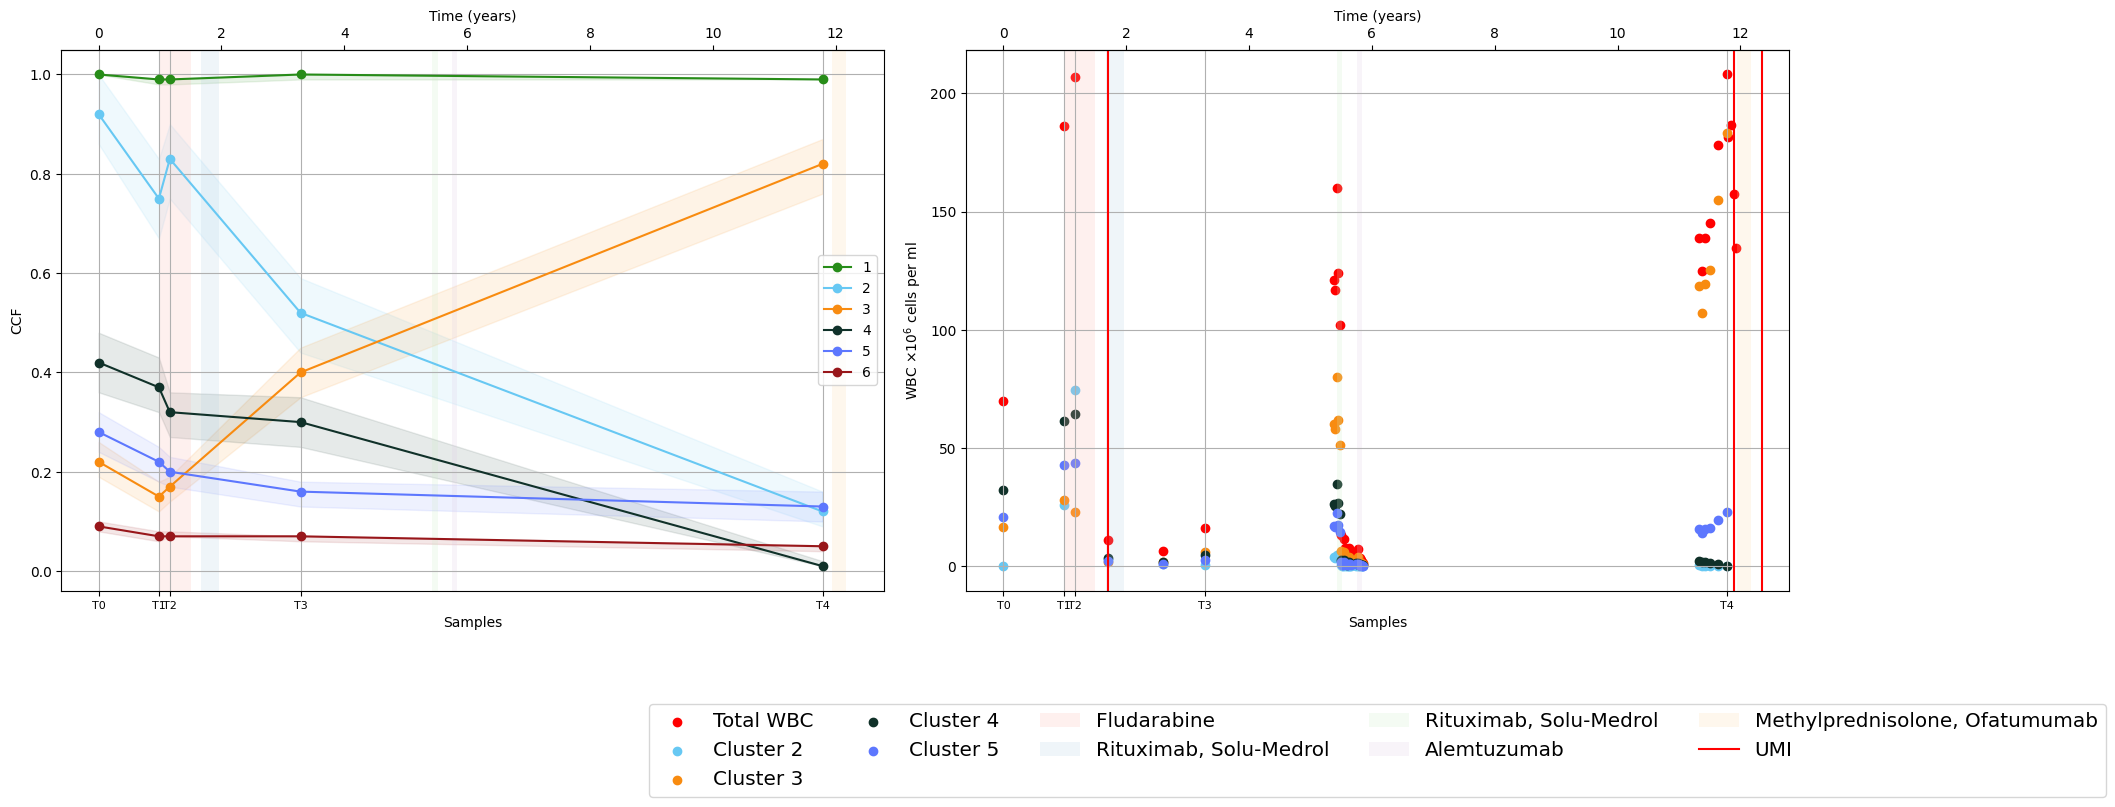

In [47]:

fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_selected)]
    ax.scatter(x_year_selected,wbc_selected, label = 'Total WBC', c = 'red')

    # plot subclones

   
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_interpolate)]
        y_sub = np.array(subclone_population[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)
        
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    ax.axvline(x=619/365, label ='UMI', color = 'red')
    ax.axvline(x=4342/365,  color = 'red')
    ax.axvline(x=4511/365,  color = 'red')

plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, [2,3,4,5])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.4),fontsize = 'x-large')
